# Makemore

## 1. Bigram Character Level Language Model

In [161]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [162]:
len(words)

32033

In [163]:
min(len(word) for word in words), max(len(word) for word in words)

(2, 15)

### 1.1 Bigram Character Level Language Model: Table Approach

In [164]:
# List of bigrams
b = {}

for word in words:
    # Adding a starting and ending indicator
    chs = ['<S>'] + list(word) + ['<E>']

    # zips emma and mma since the second string is shorter zip terminates when it encounters final character giving us em mm ma
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [165]:
# -i[i] will give descending, could also use reverse
sorted(b.items(), key= lambda i: -i[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

Above results show that it is very common for it to end with an n or a and a is often followed by an n.

In [166]:
import torch

In [167]:
'''
27x27 due to 26 letters and . for both starting and ending which is replacing <S> and <E>
This is spurious since while plotting we have useless rows like <S> followed by char and char followed by <E>, which will never happen
'''

N = torch.zeros(27, 27, dtype=torch.int32)

# Create letters for number matching
letters = sorted(list(set(''.join(words))))

# Create letter to number matching
letter_to_num = {l:num+1 for num, l in enumerate(letters)}
letter_to_num['.'] = 0

In [168]:
num_to_letter = {num:l for l,num in letter_to_num.items()}

In [169]:
# List of bigrams
b = {}

for word in words:
    chs = ['.'] + list(word) + ['.']

    for ch1, ch2 in zip(chs, chs[1:]):
        # Find row and column based on index of letters to add to the frequency of that bigram
        row = letter_to_num[ch1]
        col = letter_to_num[ch2]
        N[row, col] += 1

(-0.5, 26.5, 26.5, -0.5)

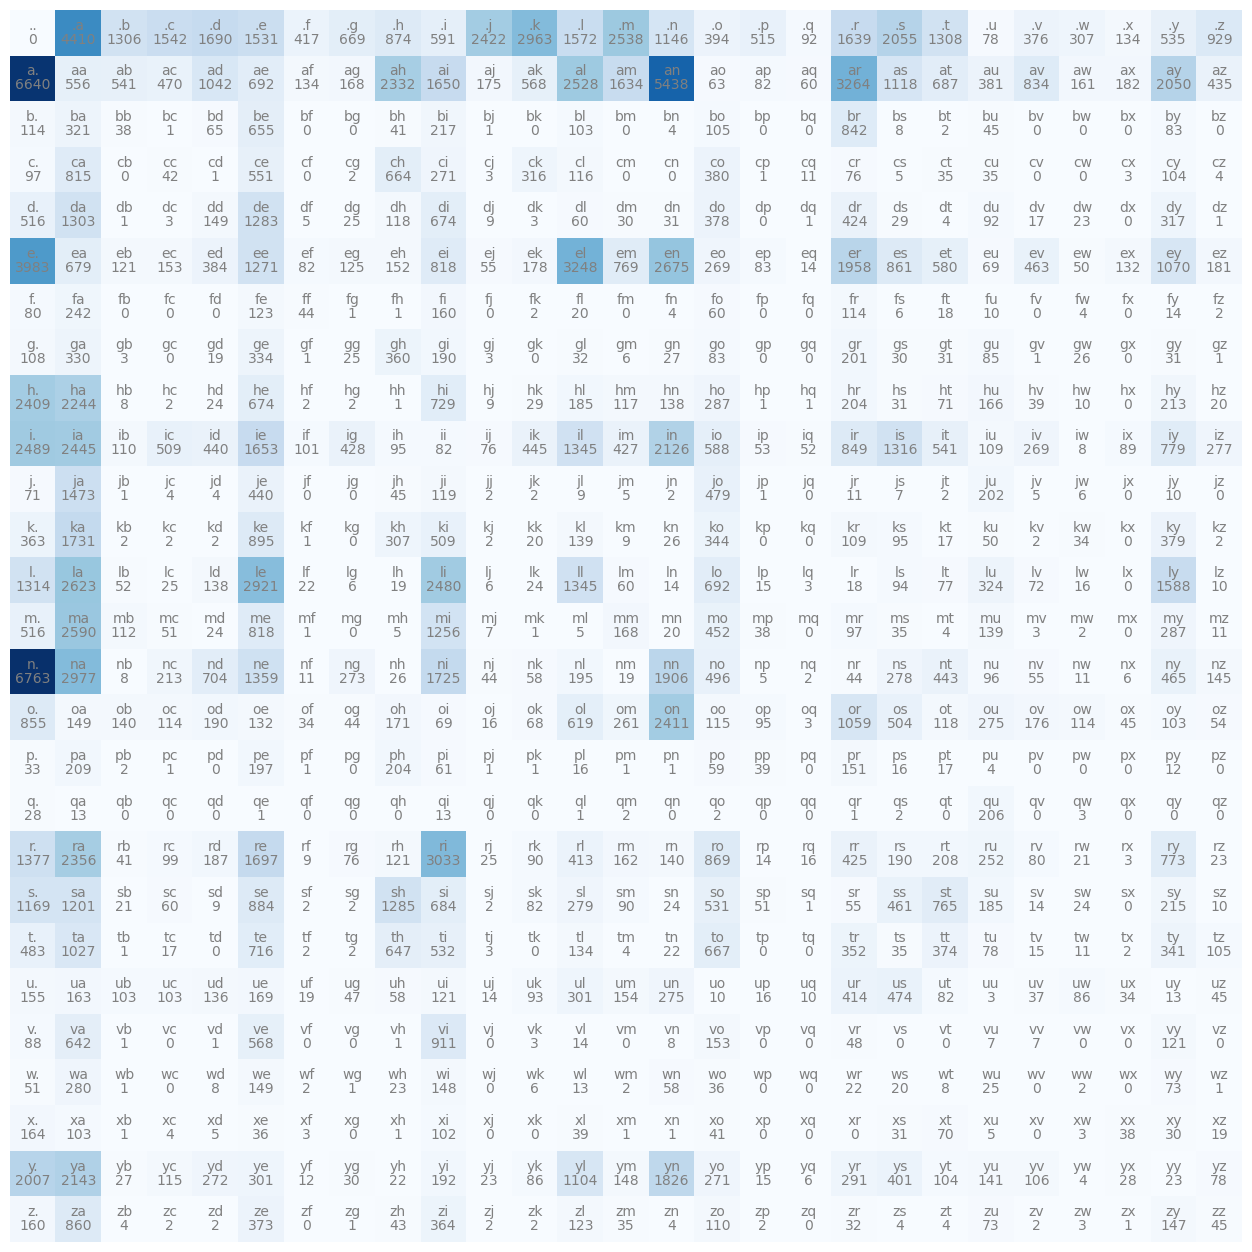

In [170]:
# Visualising the array

import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = num_to_letter[i] + num_to_letter[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')

Sampling

In [171]:
# Counts
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [172]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [173]:
# Creating a generator object for deterministic results
g = torch.Generator().manual_seed(2147483647)

# Getting probabilities of first row
p = N[0].float()
p = p / p.sum()

ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

num_to_letter[ix]

'j'

In [174]:
ix

10

In [175]:
P = N.float()
P.shape

torch.Size([27, 27])

In [176]:
P.sum(1, keepdim=True).shape

torch.Size([27, 1])

Below operation works because of broadcasting rules which states that a binary operatiorn such as division can take place between two tensors if we align their shapes from right to left and then for each dimension either they are equal, one of them is one, or one does not exist. For example: 

This is example of our P tensor and its row sum: -
Going from right to let we have one of them as 1 so it is valid and in the dimension before it both are equal.

27 27

27 1

The reason we use keep dim is if we do not, the dimensions become as follows: -

27 27

1, 27

Because it is only 27 and it is aligned from right to left the 27 moves to the right and torch automatically creates the 1 dimension, this causes an error as now it replicates the row and ends up normalising the columns instead which will cause bugs.

Broadcasting rules are very important as they can cause tricky bugs to occur, we can check for more information at the following link :
[Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html 'Broadcasting Semantics')

In [177]:
# Probability matrix is created for efficiency reasons so that probability does not need to be recomputed in the for loop
# 1 is added for smoothing so that if count is zero for some it will not give probability 0 as that will give infinite loss while calculating
P = (N + 1).float()
P /= P.sum(1, keepdim=True)

In [178]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    ix = 0
    out = []

    while True:

        p = P[ix]

        # To show how a uniform distribution ie completely untrained model gives garbage results
        # p = torch.ones(27) / 27
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        row_index = ix

        # Add to output
        out.append(num_to_letter[ix])
        
        # If ended
        if ix == 0:
            break
    
    print(''.join(out))

junide.
janasah.
p.
cony.
a.


GOAL: Maximise likelihood of the data w.r.t model parameters (statistical modelling)
* Equivalent to maximising the log likelihood (because log is monotonic)
* Equivalent to minimising the negative log likelihood
* Equivalent to minimising the average negative log likelihood

log(prob) can be simply added to likelihood despite us needing to find product as log(abc) which is what we need to find is equivalent to log(a) + log(b) + log(c)

In [179]:
log_likelihood = 0.0
n = 0

for word in ['rishabh']:
    chs = ['.'] + list(word) + ['.']

    for ch1, ch2 in zip(chs, chs[1:]):
        # Find row and column based on index of letters to add to the frequency of that bigram
        row = letter_to_num[ch1]
        col = letter_to_num[ch2]
        prob = P[row, col]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1

neg_log_likelihood = -log_likelihood


print(f'{log_likelihood=}')
print(f'{neg_log_likelihood=}')
print(f'{neg_log_likelihood/n}')

log_likelihood=tensor(-19.5194)
neg_log_likelihood=tensor(19.5194)
2.4399197101593018


2.44 gives us an idea of the overall loss of the model, the lower it is better the performance of the model and this is what we need to improve upon, if most probability values being predicted are 1, i.e, higher probability values then the nll will become lower and model will be better.

### 1.2. Bigram Character Level Language Model: Neural Network Approach

In [180]:
# Create training set of the bigrams

xs, ys = [], []

for word in words[:1]:
    chs = ['.'] + list(word) + ['.']

    for ch1, ch2 in zip(chs, chs[1:]):
        # Find row and column based on index of letters to add to the frequency of that bigram
        ix1 = letter_to_num[ch1]
        ix2 = letter_to_num[ch2]
        
        xs.append(ix1)
        ys.append(ix2)
        print(ch1, ch2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(xs)
print(ys)

. e
e m
m m
m a
a .
tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


Values need to be encoded so that they can be fed to a neural network, values are currently integer indexes of the character, logically they do not make sense to be fed into the network and then multiplied with weights, to represent the index appropriately and give information on the character it makes more sense to encode them, this can be done using one hot encoding.

In [181]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [182]:
xenc.shape, xenc.dtype

(torch.Size([5, 27]), torch.float32)

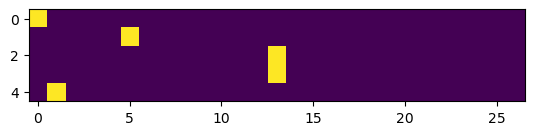

In [183]:
plt.imshow(xenc)

Above plot is a representation of the dataset that is being fed to the neural network, yellow pixels are 'on' and the rest are 'off'

In [184]:
# With a single neuron
W = torch.randn((27, 1))
xenc @ W

tensor([[-2.0663],
        [ 0.5819],
        [-2.4539],
        [-2.4539],
        [-0.5781]])

In [185]:
# With 27 neurons
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [186]:
(xenc @ W)[3, 13]

tensor(0.0379)

The information being given by the matrix multiplication of the encoded x values and the weights is the firing rate of that neuron, for example the firing rate of the 13 neuron looking at the 3 training example is -1.7634. Matrix multiplication performs the above step very efficiently to give us firing rates of all the neurons with respect to all the training examples.

In [187]:
xenc = F.one_hot(xs, num_classes=27).float() # one hot encoded inputs

In [188]:
logits = xenc @ W # log counts
counts = logits.exp() # equivalent to the N counts matrix
probs = counts / counts.sum(1, keepdim=True)
# The last two lines that is using counts and probs together are the softmax activation function

All the above operations represent steps in the forward pass, they are all differential which is a neccessity while performing backpropogation

In [189]:
probs.shape

torch.Size([5, 27])

In [190]:
nlls = torch.zeros(5)
for i in range(5):
    # ith bigram
    x = xs[i].item()
    y = ys[i].item()
    print('-' * 130)
    print(f'Bigram example {i+1}: {num_to_letter[x], num_to_letter[y]}, (indexes {x}, {y})')
    print(f'Input to neural net: {x}')
    print(f'Output probabilities from neural net: {probs[i]}')
    print(f'Label (actual next character): {y}')
    p = probs[i, y]
    print(f'Probability assigned by net to correct character: {p}')
    logp = torch.log(p)
    print(f'Log likelihood: {logp.item()}')
    nll = -logp
    print(f'Negative log likelihood: {nll.item()}')
    nlls[i] = nll

print(f'Average negative log likelihood: {nlls.mean().item()}')

----------------------------------------------------------------------------------------------------------------------------------
Bigram example 1: ('.', 'e'), (indexes 0, 5)
Input to neural net: 0
Output probabilities from neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
Label (actual next character): 5
Probability assigned by net to correct character: 0.012286253273487091
Log likelihood: -4.3992743492126465
Negative log likelihood: 4.3992743492126465
----------------------------------------------------------------------------------------------------------------------------------
Bigram example 2: ('e', 'm'), (indexes 5, 13)
Input to neural net: 5
Output probabilities from neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.07

#### Optimisation of neural network weights

In [191]:
# Creating a dataset

xs, ys = [], []
for word in words:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = letter_to_num[ch1]
        ix2 = letter_to_num[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f'Number of examples: {num}')

Number of examples: 228146


In [192]:
# Initialisation of network

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)
print(f'Weights shape: {W.shape}')

Weights shape: torch.Size([27, 27])


In [193]:
# Number of iterations

for i in range(100):
    # Forward Pass
    xenc = F.one_hot(xs, num_classes=27).float()                                # One hot encoding to be fed to network
    logits = xenc @ W                                                           # Log counts 

    # Softmax Activation Function
    counts = logits.exp()                                                       # Equivalent to N
    probs = counts / counts.sum(1, keepdim=True)                                # Probabilities of next character
    
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()      # Negative Log Likelihood with Regularisation
    
    # Backward Pass
    W.grad = None
    loss.backward()

    # Weight updation
    W.data += -50 * W.grad

    print(f'Iteration {i+1}: Loss: {loss}')

Iteration 1: Loss: 3.7686190605163574
Iteration 2: Loss: 3.3788061141967773
Iteration 3: Loss: 3.1610891819000244
Iteration 4: Loss: 3.027184247970581
Iteration 5: Loss: 2.934483051300049
Iteration 6: Loss: 2.867230176925659
Iteration 7: Loss: 2.8166537284851074
Iteration 8: Loss: 2.7771458625793457
Iteration 9: Loss: 2.745253324508667
Iteration 10: Loss: 2.7188303470611572
Iteration 11: Loss: 2.696505308151245
Iteration 12: Loss: 2.6773717403411865
Iteration 13: Loss: 2.6608052253723145
Iteration 14: Loss: 2.6463513374328613
Iteration 15: Loss: 2.633665084838867
Iteration 16: Loss: 2.622471332550049
Iteration 17: Loss: 2.6125476360321045
Iteration 18: Loss: 2.6037068367004395
Iteration 19: Loss: 2.595794916152954
Iteration 20: Loss: 2.5886809825897217
Iteration 21: Loss: 2.5822560787200928
Iteration 22: Loss: 2.5764293670654297
Iteration 23: Loss: 2.5711238384246826
Iteration 24: Loss: 2.566272735595703
Iteration 25: Loss: 2.5618226528167725
Iteration 26: Loss: 2.5577263832092285
Iter

The final loss is very similar to the normal approach of a bigram language model that simply used count of the bigrams within the dataset for the probabilities, the reason the performance is so similar is because the bigram language model is very straightforward and so using the simple table of having all count probabilities works, the gradient learning method however is more flexible and can be used in more scenarios where we could increase the length of the sequence of characters being used to predict the next character.

**Notes:** 
1. The W ie weight matrix found in the gradient based problem is equivalent to the the blue matrix that had all the counts that we used for bigram language model in the first part (when we did not use a neural network), they are the same the only difference being that it is equivalent to the .exp() of the previous table since it is simply just counts.
2. In the above process although we are performing matrix multiplication xenc @ W, since xenc is a one hot encoded tensor, it is simply selecting the appropriate row of the Weight matrix which is similar to the lookup operation we were performing in part 1. The only difference is that in the first part we simply used the existing counts within the dataset to get the table at the beginning and in the neural network approach we kept updating the values of the weights by optimising using gradient descent. 
3. Another point of note is that trying to incentivize W to be close to 0 is similar to the smoothing operation performed in part 1 (N+1), this is because if W are all close to 0, then the probabilities will become uniform. This process of incentivizing W to be close to zero is called **regularisation**. In the above process that would be the (W**2).mean() (usually that would be sum, however in this case sum would give a very large value) When we add regularisation model is trying to achieve two goals, one is to have the probabilities being predicted to be as accurate as possible (match output), two is drive weights to have lower values (regularisation).

#### Sampling from the network

In [194]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    ix = 0
    out = []

    while True:

        # Without Neural Network
        p = P[ix]

        # Neural Network approach
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()                                
        logits = xenc @ W   # predict log counts                                                           

        # Softmax Activation Function
        counts = logits.exp() # counts, equivalent to N                                                  
        probs = counts / counts.sum(1, keepdim=True) # probabilities for next character
        
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        # Add to output
        out.append(num_to_letter[ix])
        
        # If ended
        if ix == 0:
            break
    
    print(''.join(out))

junide.
janasah.
p.
cfay.
a.


Sampling just further proves models are achieving the same results

## 2. Multilayer Perceptron: MLP

Models are based on paper: [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

### Part 1:

In [195]:
import torch

In [196]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [197]:
len(words)

32033

In [198]:
min(len(word) for word in words), max(len(word) for word in words)

(2, 15)

In [199]:
# Building vocabulary of all letters and the mapping from letters to numbers and vice versa
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [200]:
# Build a dataset

block_size = 3
X, Y = [], []

for word in words[:5]:
    context = [0] * block_size
    print(word)
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(f"{' '.join([itos[i] for i in context])} -> {itos[ix]}")
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
. . . -> e
. . e -> m
. e m -> m
e m m -> a
m m a -> .
olivia
. . . -> o
. . o -> l
. o l -> i
o l i -> v
l i v -> i
i v i -> a
v i a -> .
ava
. . . -> a
. . a -> v
. a v -> a
a v a -> .
isabella
. . . -> i
. . i -> s
. i s -> a
i s a -> b
s a b -> e
a b e -> l
b e l -> l
e l l -> a
l l a -> .
sophia
. . . -> s
. . s -> o
. s o -> p
s o p -> h
o p h -> i
p h i -> a
h i a -> .


In [201]:
X.shape, X.dtype, Y.shape, Y.dtype,

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [202]:
# C is our lookup table, which is the embeddings for the characters initially weights for this table will be random

C = torch.randn((27, 2))
C.shape

torch.Size([27, 2])

In [203]:
# Usually one hot encoded values are multiplied with the matrix C
# xenc @ W
# This is however the same as just taking out the appropriate row from matrix C i.e indexing it by X, so we can simply just index

emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [204]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

We would want to multiply the embeddings and the weights but [32, 3, 2] and [6, 100], are not compatible so we will concatenate the three embeddings so that this becomes possible

In [205]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

Issue that arises with the previous code is that if we changed the block size we would need to explicitly change and go till emb[:, 5, :], another way of doing this would be to use torch.unbind which returns the same equivalent results of the different indexes of that dimension in a tuple.

In [206]:
len(torch.unbind(emb, dim=1))

3

In [207]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

In [208]:
a = torch.arange(10)
a.shape

torch.Size([10])

In [209]:
a.view((2, 5))

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

Each tensor has a function called storage, which is how it is stored in memory, view simply uses some functions of storage to manipulate its representation. This makes it very efficient and preferred over our previous method of concatenating. Concatenate is less efficient as it needs to create new storage.

In [210]:
emb.view((32, 6)).shape

torch.Size([32, 6])

In [211]:
torch.equal(torch.cat(torch.unbind(emb, dim=1), dim=1), emb.view((32, 6)))

True

Shows that the two methods give the same results, now multiplication can be performed.

In [212]:
h = torch.tanh(emb.view((emb.shape[0], 6)) @ W1 + b1)
h, h.shape

(tensor([[ 0.9999,  0.5989, -0.9885,  ..., -0.5431, -0.2131,  0.6643],
         [ 0.9995,  0.9400, -0.7285,  ...,  0.9302,  0.9143,  0.9970],
         [ 0.9978,  0.8136, -0.9466,  ..., -0.6335,  0.6113, -0.9405],
         ...,
         [ 0.9997,  0.9380,  0.1151,  ...,  0.8577,  0.9982,  0.9552],
         [-0.9620, -0.6934,  0.0314,  ...,  0.9731,  0.1758,  0.9953],
         [ 0.9915, -0.8951, -0.9770,  ..., -0.8695, -0.8337, -0.5429]]),
 torch.Size([32, 100]))

In [213]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [214]:
# Weighted sum
logits = (h @ W2 + b2)

# Softmax activation
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

In [215]:
probs.shape

torch.Size([32, 27])

In [216]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(13.8747)

In [217]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [218]:
g = torch.Generator().manual_seed(2147483647)

# Embedding representations
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]

In [219]:
sum(p.nelement() for p in parameters)

3481

In [220]:
emb = C[X]

h = torch.tanh(emb.view((32, 6)) @ W1 + b1)

logits = h @ W2 + b2 # log counts

loss = F.cross_entropy(logits, Y) # equivalent to using counts, probs and then finding nll
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

The reason for using F.cross_entropy over the previous method of finding counts, probs and then loss are multifold: -
1. Previous method created new tensors for each of the operations which takes up a lot of place in memory, cross entropy on the other hand does not do this
2. Calculating gradient for F.cross_entropy is much simpler than for previous method where it must be calculated for each operation, this was seen in micrograd as well where tanh forward pass was a large mathematical operation but its gradient was simple to calculate.
3. Much more numerically well behaved, for example, if there is a large positive number in the logits tensor, while finding exponent it will become infinity, this will in turn give a nan result in probs, the way torch fixes this is by finding the largest number in the tensor and subtracting it (logits - max(logits)) this is called offsetting and does not affect the probability distribution and by doing this the inf and nan problem is solved. F.cross_entropy does this under the hood so it is preferred since it does not throw such errors.

In [407]:
# Build a dataset

def build_dataset(words):
    block_size = 3  # context length: how many characters are taken to predict the next one
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

X, Y = build_dataset(words)

In [408]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [251]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [290]:
g = torch.Generator().manual_seed(2147483647)

# Embedding representations
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]

In [291]:
sum(p.nelement() for p in parameters)

3481

In [292]:
for p in parameters:
    p.requires_grad = True

In [293]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [294]:
lri = []
lossi = []

for i in range(1000):

    # Minibatch construct: size - 32
    ix = torch.randint(0, X.shape[0], (32,))

    emb = C[X[ix]] # Original: (228146, 3, 2), Using mini-batch: (32, 3, 2)

    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2 # log counts

    loss = F.cross_entropy(logits, Y[ix])

    for p in parameters:
        p.grad=None

    # print(f"Iteration {_+1}: Loss {loss.item()}")
    loss.backward()

    lr = lrs[i]

    for p in parameters:
        p.data += -lr*p.grad
    
    # Track for finding ideal learning rate
    lri.append(lre[i])
    lossi.append(loss.item())

print(loss.item())

6.546849727630615


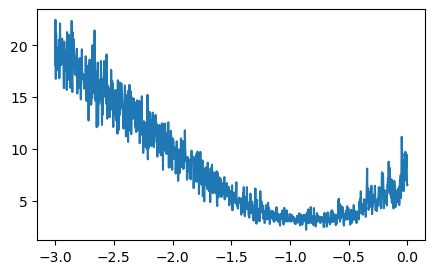

In [296]:
plt.figure(figsize=(5, 3))
plt.plot(lri, lossi)

Ideal learning rate can be seen as being at around 10**-1 = 0.1. 

Running the whole process again with the ideal learning rate, for the last few times will running the cell reduce learning rate by dividing it by 10, this is known as learning rate decay, this is done to take smaller steps while reaching the end of training the model

In [423]:
g = torch.Generator().manual_seed(2147483647)

# Embedding representations
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [435]:
stepi = []
lossi = []

for i in range(30000):

    # Minibatch construct: size - 32
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]] # Original: (228146, 3, 2), Using mini-batch: (32, 3, 2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2 # log counts

    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad=None

    # print(f"Iteration {_+1}: Loss {loss.item()}")
    loss.backward()

    lr = 0.01 # Ideal learning rate that was found, keep this value for first couple times and then reduce it to 0.01 for lr decay

    for p in parameters:
        p.data += -lr*p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.item())

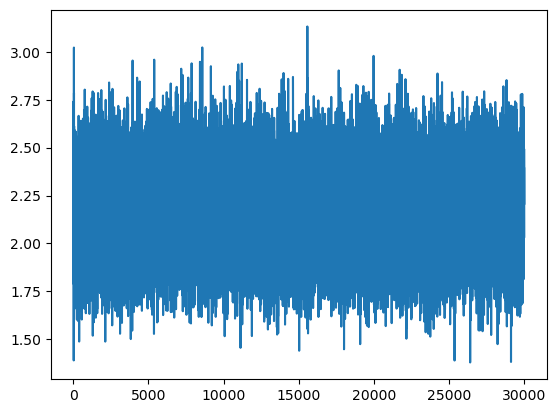

In [436]:
plt.plot(stepi, lossi)

In [437]:
# Computing loss on train dataset
emb = C[Xtr] # (228146, 3, 2)
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1544413566589355


In [438]:
# Computing loss on val dataset
emb = C[Xval] # (228146, 3, 2)
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(loss.item())

2.3223772048950195


The issue with the above model is that despite loss being shown to be low, if we sample from it, the model will give results that are the same as from the dataset, it will also not perform well on unseen examples, the reason for this is overfitting, model has memorised the data rather than learnt underlying patterns. A way of solving this problem is to have three splits in the dataset:-
1. Training split: majority of the data, this is used for training the dataset
2. Validation/Dev split: used for tuning of hyperparameters to see how performance changes 
3. Test split: used for final evaluation of the model on unseen data

Model despite various experiments is still not performing well so we will first visualise embeddings and then since we have even changed number of neurons in hidden layer, it can be assumed that the bottleneck is caused due to lijmited embedding size, trying to increase it might increase performance.

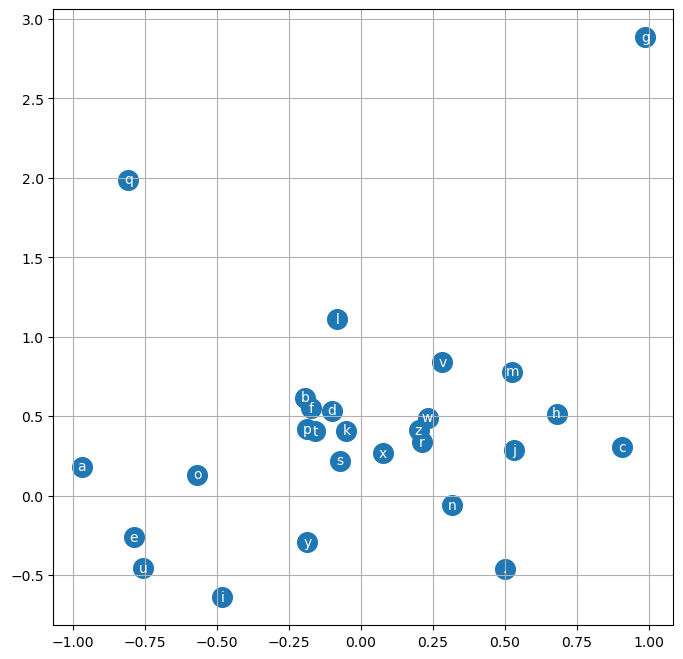

In [440]:
# Visualise embeddings

plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

By seeing the visualisations we can see how the vowels have similar embeddings, q is being treated as an exception, and . is also being left away. This can be visualised since it is only a 2D embedding.

Running model again but with a larger embedding size

In [483]:
g = torch.Generator().manual_seed(2147483647)

# Embedding representations
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 100), generator=g) # 3* 10 for block length * embedding size
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# Parameters
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

Number of parameters: 6097


In [484]:
stepi = []
lossi = []

In [485]:
for i in range(200000):

    # Minibatch construct: size - 32
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]] # Original: (228146, 3, 2), Using mini-batch: (32, 3, 2)
    h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
    logits = h @ W2 + b2 # log counts

    loss = F.cross_entropy(logits, Ytr[ix])

    for p in parameters:
        p.grad=None

    # print(f"Iteration {_+1}: Loss {loss.item()}")
    loss.backward()

    lr = 0.01 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr*p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

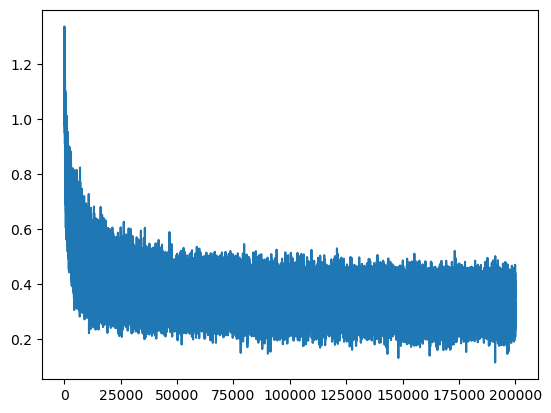

In [486]:
plt.plot(stepi, lossi)

In [487]:
# Computing loss on train dataset
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.160123348236084


In [488]:
# Computing loss on val dataset
emb = C[Xval]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
print(loss.item())

2.35284686088562


#### Sampling from the model

In [492]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) 
        logits = h @ W2 + b2 # log counts
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    
    print(''.join(itos[i] for i in out))

junnde.
janasim.
presty.
adie.
kaitrito.
sabastie.
kalinaarianilen.
ashibini.
roi.
tavina.
iely.
arley.
nraulesya.
demmer.
fynslen.
ruann.
core.
yae.
ocaha.
jamille.


### Part 2:

In [87]:
import torch
import torch.nn.functional as F

In [88]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [89]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [90]:
# Build a dataset

def build_dataset(words):
    block_size = 3  # context length: how many characters are taken to predict the next one
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [91]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

Xtr.shape, Ytr.shape, Xval.shape,Yval.shape, Xtest.shape, Ytest.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [114]:
n_emb = 10  # size of embeddings
n_hidden = 200  # number of neurons in hidden layer
vocab_size = len(stoi)  # number of unique characters in vocabulary
block_size = 3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) # Embedding representations
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * ((5/3) / (block_size*n_emb)**0.5)  # multiplied with gain / root of fanin
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # removed as we are using bnbias, since we use mean and subtract (check batchnorm), gradient of b1 will be 0
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # to keep initial value of W2 low so that while predicting logits gives uniformity
b2 = torch.randn(vocab_size, generator=g) * 0 # keep inital bias 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) # multiplied with standardised x to scale and shift values to ensure neural net has some flexibility and ...
bnbias = torch.zeros((1, n_hidden)) # ... does not always force gaussian dist., bias is added
bnmean_running = torch.ones((1, n_hidden)) # keep track of bnmeans so that while evaluating and when finding result, we dont need a batch as input
bnstd_running = torch.zeros((1, n_hidden))

# Parameters
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

Number of parameters: 12097


Uniformity in logits for the first prediction is important as it ensures we have a low loss for first step which was not happening without reducing values of W2 and making b2 0. For first iteration we want these logits to be uniform due to the assumption that all characters have an equal chance of being selected. W1 and b1 also need their values to be reduced as it was causing the vanishing gradient problem due to large amount of values being close to -1 and 1, so reducing their values should solve the problem. 

We have multiplied W1 with gain / root of fanin, this is according to the [kaiming initialisation](https://pytorch.org/docs/stable/nn.init.html)  which uses formula to directly give us the best value to multiply the weight with for the tanh, the formula will change depending on the activation function being used.

In [115]:
batch_size = 32
max_steps = 200000
lossi = []

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward Pass
    emb = C[Xb] # get embeddings
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors

    # Linear Layer
    hpreact = embcat @ W1 # + b1 # pre activation, b1 removed as bnbias is used for biasing, since we add b and then subtract bnmeani, it effectively is useless

    # Batch Norm Layers
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias  # Batch Normalisation
    # Following statements are just for updating so they dont need to be added to expression graph for backprop
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001*bnstdi

    # Hidden Layer - nonlinearity
    h = torch.tanh(hpreact) # after activation

    # Output Layer
    logits = h @ W2 + b2 # log counts
    
    loss = F.cross_entropy(logits, Yb) # loss computation

    # Resetting gradient
    for p in parameters:
        p.grad=None

    # Backpropogation
    loss.backward()

    # Update values of weights and biases
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    # Track stats
    if i%10000==0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break  # used to check h, hpreact to see effect of vanishing gradient and saturation of activation as well as how first loss value is high

      0 /  200000: 3.3163
  10000 /  200000: 1.9470
  20000 /  200000: 2.4029
  30000 /  200000: 2.0819
  40000 /  200000: 2.6142
  50000 /  200000: 2.1708
  60000 /  200000: 2.4714
  70000 /  200000: 2.3300
  80000 /  200000: 1.7649
  90000 /  200000: 2.2236
 100000 /  200000: 1.9658
 110000 /  200000: 2.1202
 120000 /  200000: 2.4251
 130000 /  200000: 2.0385
 140000 /  200000: 2.1127
 150000 /  200000: 1.8670
 160000 /  200000: 2.4926
 170000 /  200000: 1.9419
 180000 /  200000: 1.8589
 190000 /  200000: 2.0614


(array([ 931.,  628.,  509.,  506.,  505.,  455.,  521.,  594.,  710.,
        1041.]),
 array([-9.99299347e-01, -7.99397093e-01, -5.99494839e-01, -3.99592584e-01,
        -1.99690330e-01,  2.11924314e-04,  2.00114179e-01,  4.00016433e-01,
         5.99918687e-01,  7.99820942e-01,  9.99723196e-01]),
 <BarContainer object of 10 artists>)

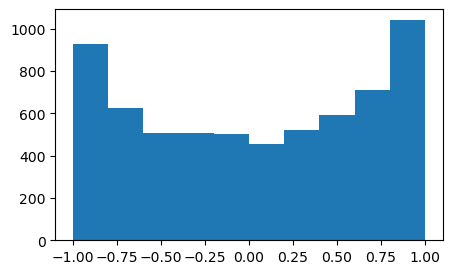

In [67]:
plt.figure(figsize=(5, 3))
plt.hist(h.view(-1).tolist())

(array([  12.,   88.,  433., 1167., 1910., 1727.,  774.,  240.,   40.,
           9.]),
 array([-3.97814226, -3.13606577, -2.29398928, -1.45191278, -0.60983629,
         0.2322402 ,  1.07431669,  1.91639318,  2.75846968,  3.60054617,
         4.44262266]),
 <BarContainer object of 10 artists>)

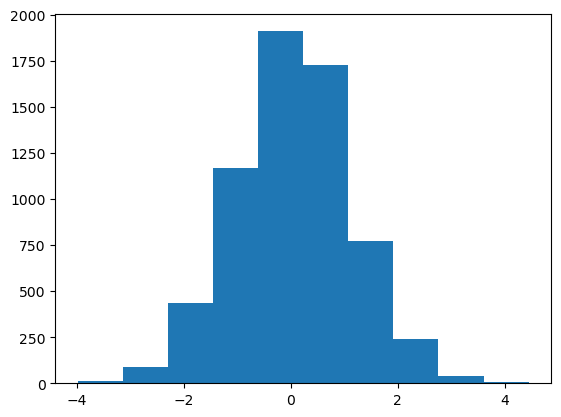

In [68]:
plt.hist(hpreact.view(-1).tolist())

Majority of the values of h are -1 and 1 this causes an issue because when backpropogating, the way tanh works is by multiplying gradient with ( 1 - t**2), and this gives us 0 for both -1 and 1, which causes the value to become 0 and so those neurons do not learn. This is know as a vanishing gradient problem, and it occurs with activation functions like tanh, sigmoid. 

While seeing the hpreact values the change is too large causing saturation of tanh activation function with large amounts of values at -1 and 1. (Run the above cells without the multiplying weights and biase with 0.1, 0.01 to see the difference)

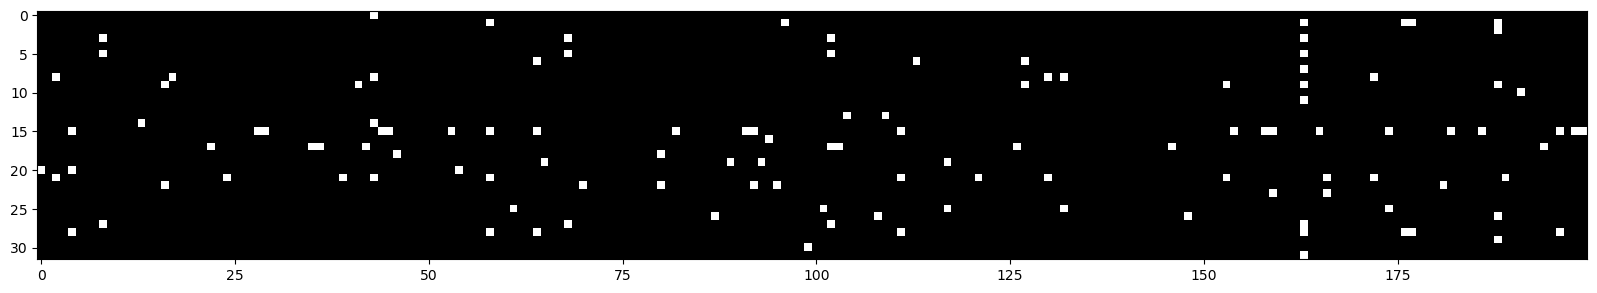

In [69]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

White is the values that are -1 or 1, this is a representation of the neurons as it is 32 x 200 for for 200 neurons each taking 32 training examples, if there is a complete white column that signifies that the neurons are dead and not learning from those examples.

Prior to adjusting weights by multiplying them, first loss recorded is very high, this means that the weights of the net are not being initialised well leading to a high loss, the model is very confidently wrong. The expected loss can be calculated by simply assuming that all characters are equally likely to be generated in the first iteration.

In [29]:
# Loss if all characters have same probability
-torch.tensor(1/27.0).log()

tensor(3.2958)

The result is much lower than 27 so it is obvious that weight initialisation is not proper.

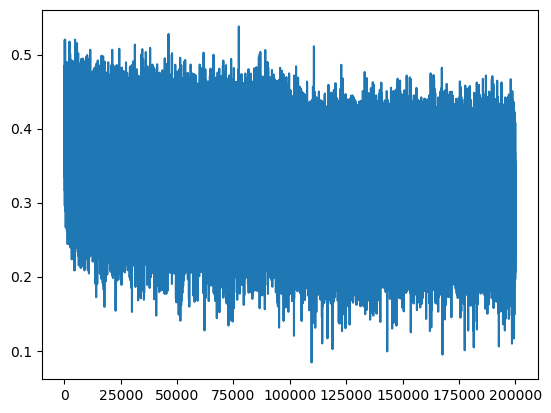

In [41]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.plot(lossi)

Not as dramatic as previous as now the first few steps do not have large loss, due to weight initialisation.

In [116]:
@torch.no_grad() # Decorator disbles gradient tracking, done so that torch does not need to keep track of any gradients for tensors created here
def split_loss(split):
    X, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[Xb] # get embeddings
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors
    hpreact = embcat @ W1 + b1 # pre activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)  + bnbias  # Batch Normalisation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running  + bnbias
    h = torch.tanh(hpreact) # after activation
    logits = h @ W2 + b2 # log counts
    loss = F.cross_entropy(logits, Yb) # loss computation
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8866010904312134
val 1.8866010904312134


**Model Results:**

**Original**
* train 2.0982091426849365
* val 2.0982091426849365

**Fixing softmax confidently wrong (by multiplying w2, b2 with 0.01)**
* train 1.9858404397964478
* val 1.9858404397964478

**Fixing saturation of tanh (by multiplying w1, b1 with 0.2, 0.01)**
* train 1.8389637470245361
* val 1.8389637470245361

**Add batch normalisation layer**
* train 1.8866010904312134
* val 1.8866010904312134

In [28]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) 
        logits = h @ W2 + b2 # log counts
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        # If sample result is '.' then break as it means end
        if ix==0:
            break
    
    print(''.join(itos[i] for i in out))

junide.
jakayah.
parlay.
adin.
kairrito.
cassa.
ezmanianaanvin.
levias.
deyaine.
imells.
jainayla.
ter.
aveum.
kyn.
demmerchynsleigh.
ani.
core.
yae.
ocely.
jamir.


### Part 3: Recreating by using classes

Goal is to recreate [pytorch](https://pytorch.org/docs/stable/nn.html) implementations of the layers, used for the MLP.

In [155]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # used as behvaiour differs whether we are using it for training or eval
        # Parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers trained with running momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / (torch.sqrt(xvar + self.eps))
        self.out = self.gamma * xhat + self.beta

        # Update buffers
        if self.training:
            self.running_mean = (1-self.momentum) * self.running_mean + self.momentum  * xmean
            self.running_var = (1-self.momentum) * self.running_var + self.momentum  * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

#### Without Batch Norm

In [156]:
vocab_size = 27 # number of characters in vocabulary
block_size = 3 # size of sequence taken to make predictions
n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 100 # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear( n_embed * block_size, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), Tanh(),
    Linear(             n_hidden, vocab_size),
]
with torch.no_grad():
    # last layer make less confident
    layers[-1].weight *= 0.1
    # apply gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # gain of 5/3 is used to fight the squashing effect of the tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

36397


In [157]:
batch_size = 32
max_steps = 200000
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward Pass
    emb = C[Xb] # get embeddings
    x = emb.view(emb.shape[0], -1) # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward Pass
    for layer in layers:
        layer.out.retain_grad()
    # Resetting gradient
    for p in parameters:
        p.grad=None
    loss.backward()

    # Update values of weights and biases
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    # Track stats
    if i%10000==0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break  # used only while debugging

      0 /  200000: 3.3145


Visualisation shown below are useful to check whether the neural net has been calibrated appropriately, if too much discrepancy is seen it means we have not calibrated it appropriately.

layer 1 (      Tanh): mean -0.03, std 0.77, saturated: 22.62%
layer 3 (      Tanh): mean -0.00, std 0.73, saturated: 12.91%
layer 5 (      Tanh): mean +0.00, std 0.74, saturated: 12.50%
layer 7 (      Tanh): mean +0.01, std 0.72, saturated: 9.97%


Text(0.5, 1.0, 'Activation Distribution')

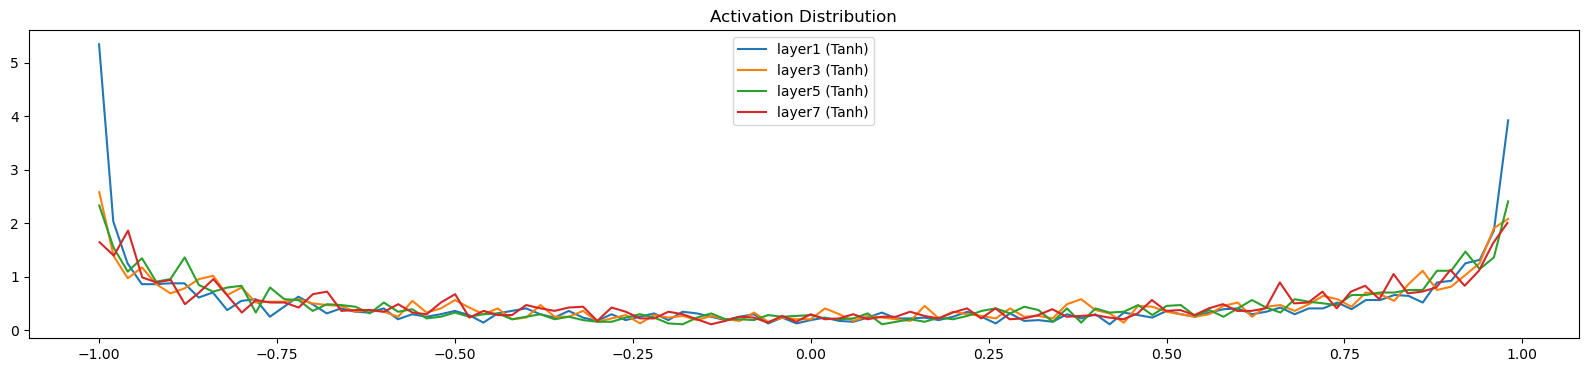

In [158]:
# Visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluding output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')

layer 1 (      Tanh): mean +0.00, std 2.699235e-03
layer 3 (      Tanh): mean +0.00, std 2.692688e-03
layer 5 (      Tanh): mean +0.00, std 2.673389e-03
layer 7 (      Tanh): mean +0.00, std 2.303166e-03


Text(0.5, 1.0, 'Activation Distribution')

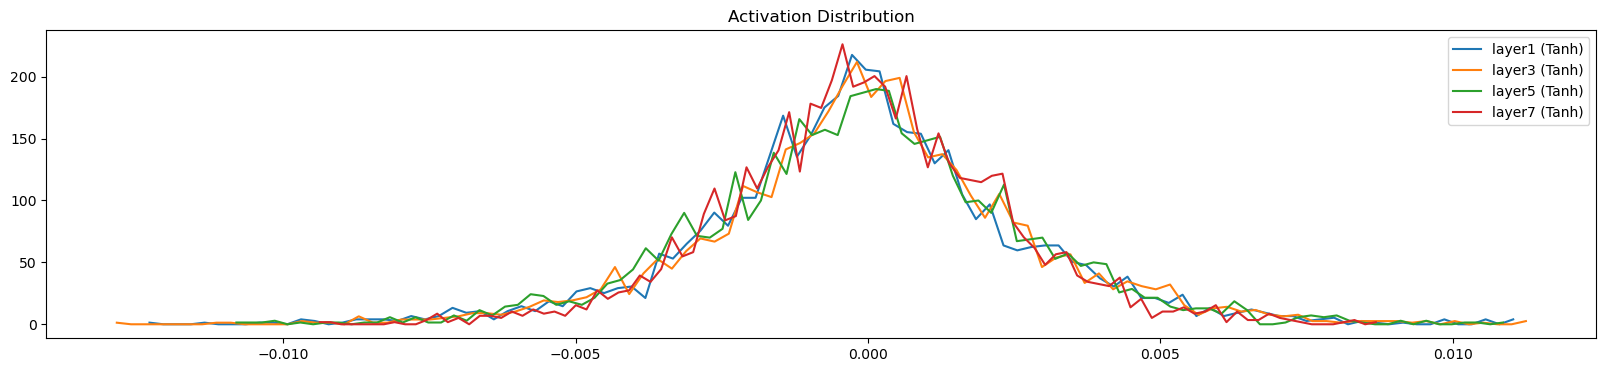

In [159]:
# Visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluding output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')

weight   (27, 10) | mean +0.000517 | std 9.455121e-03 | grad:data ratio 9.444130e-03
weight  (30, 100) | mean -0.000130 | std 8.438562e-03 | grad:data ratio 2.695339e-02
weight (100, 100) | mean -0.000094 | std 6.939482e-03 | grad:data ratio 4.122947e-02
weight (100, 100) | mean +0.000075 | std 6.210399e-03 | grad:data ratio 3.659986e-02
weight (100, 100) | mean -0.000034 | std 5.234926e-03 | grad:data ratio 3.106379e-02
weight  (100, 27) | mean +0.000000 | std 2.061020e-02 | grad:data ratio 2.868452e-01


Text(0.5, 1.0, 'Weights Gradient Distribution')

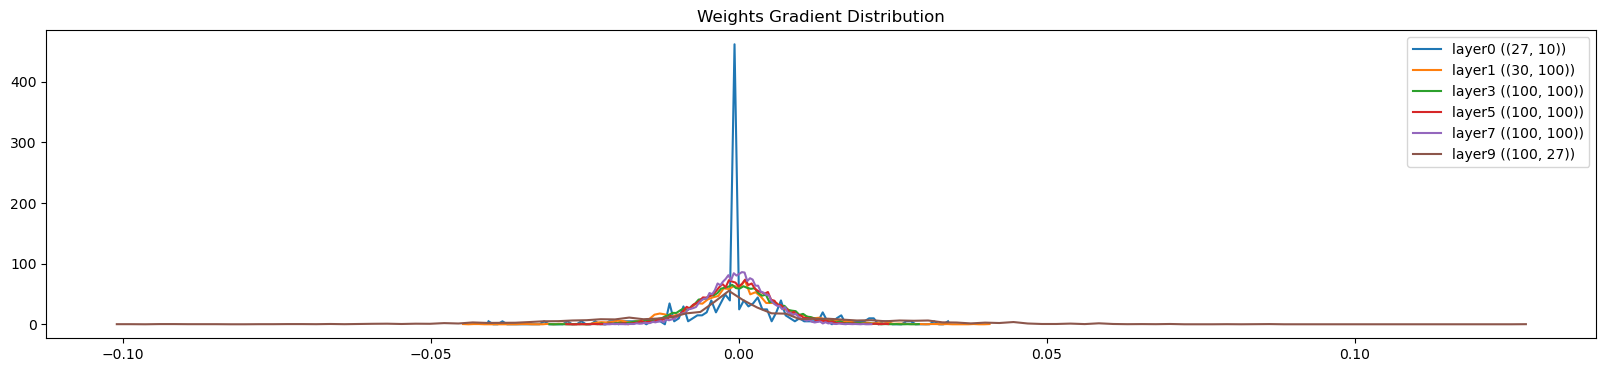

In [160]:
# Visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # dim 2 makes it only check for weights not biases, gamma and beta
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('Weights Gradient Distribution')

Text(0.5, 1.0, 'Update to Gradient Distribution')

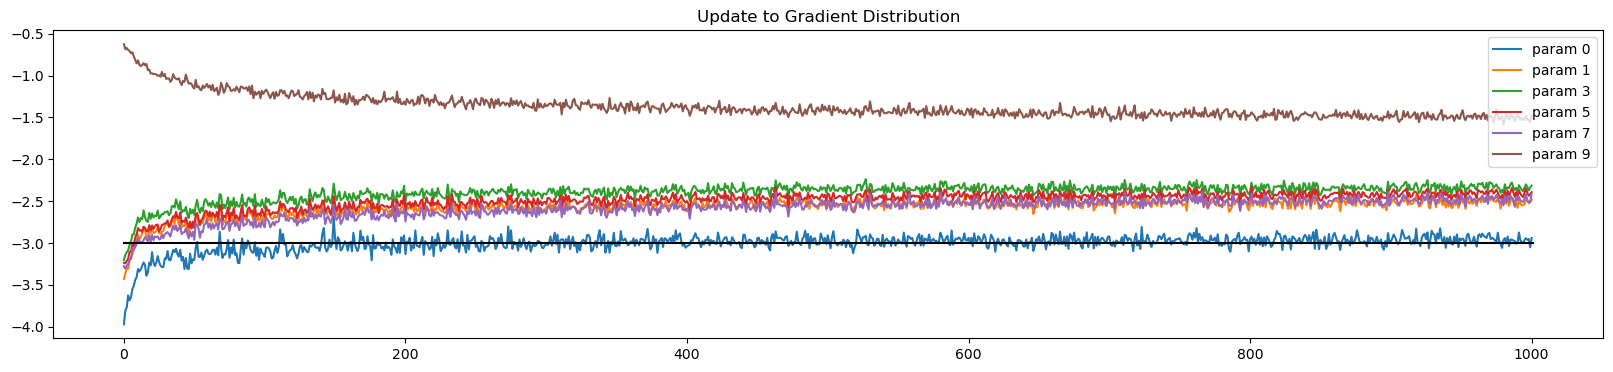

In [152]:
# Visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # dim 2 makes it only check for weights not biases, gamma and beta
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k') # values of 1e-3, indicate on plot
plt.legend(legends)
plt.title('Update to Gradient Distribution')

If in the above plot there are a lot of values below the black line then that means the learning rate is too small, the reason the output layer update is much higher is because we are multiplying it by 0.1 to remove the overconfidence of the final layer.

Note: the main issue with the above approach is the fact that there can be various issues as it is quite hard to properly tune the neural net such as its gain etc, using a batch norm layers could solve this problem.

#### Using Batch Norm

In [161]:
vocab_size = 27 # number of characters in vocabulary
block_size = 3 # size of sequence taken to make predictions
n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 100 # number of hidden neurons

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear( n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(             n_hidden, vocab_size), BatchNorm1d(vocab_size),
]
with torch.no_grad():
    # last layer make less confident
    # layers[-1].weight *= 0.1 # not used as last layer is now batch norm
    layers[-1].gamma *= 0.1
    # apply gain to all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # gain of 5/3 is used to fight the squashing effect of the tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

37251


In [162]:
batch_size = 32
max_steps = 200000
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward Pass
    emb = C[Xb] # get embeddings
    x = emb.view(emb.shape[0], -1) # concatenate vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward Pass
    for layer in layers:
        layer.out.retain_grad()
    # Resetting gradient
    for p in parameters:
        p.grad=None
    loss.backward()

    # Update values of weights and biases
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad

    # Track stats
    if i%10000==0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break  # used only while debugging

      0 /  200000: 3.2964


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.25%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.47%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.38%


Text(0.5, 1.0, 'Activation Distribution')

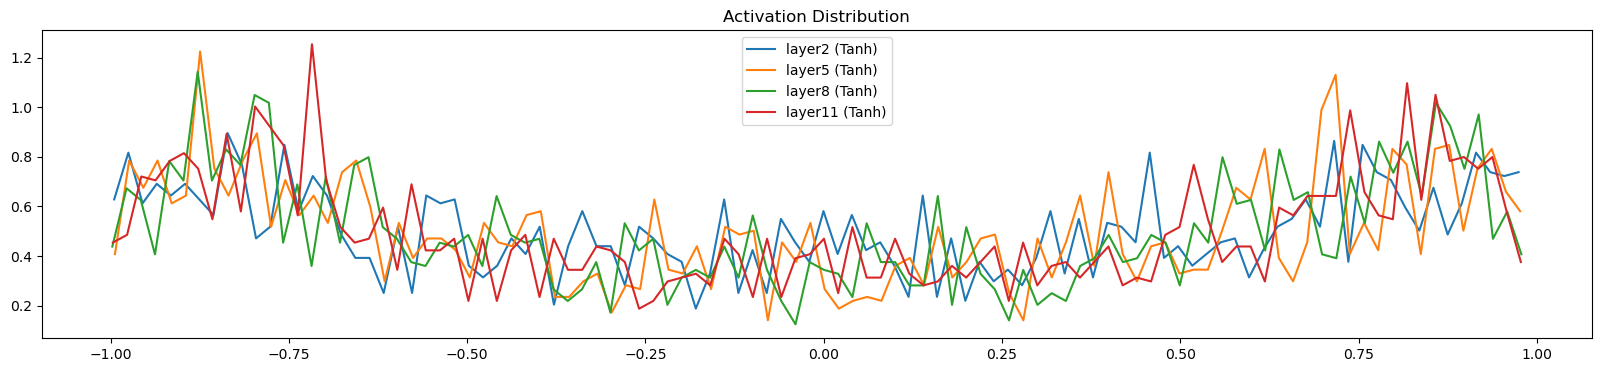

In [163]:
# Visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluding output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')

layer 2 (      Tanh): mean -0.00, std 3.557624e-03
layer 5 (      Tanh): mean -0.00, std 2.858727e-03
layer 8 (      Tanh): mean -0.00, std 2.592528e-03
layer 11 (      Tanh): mean -0.00, std 2.323194e-03


Text(0.5, 1.0, 'Activation Distribution')

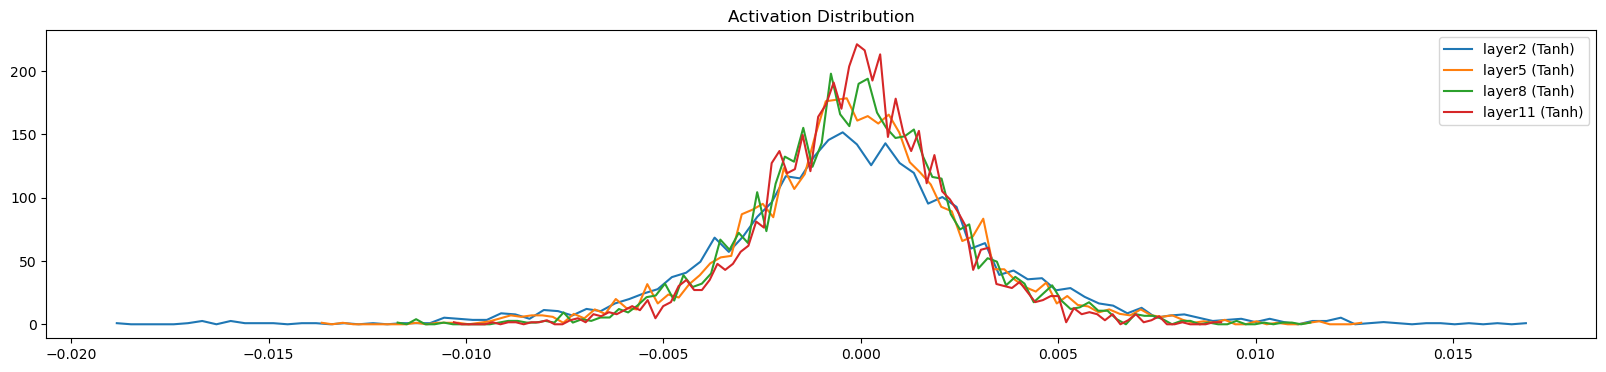

In [164]:
# Visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # excluding output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution')

weight   (27, 10) | mean +0.000000 | std 6.829781e-03 | grad:data ratio 6.823207e-03
weight  (30, 100) | mean -0.000042 | std 7.597282e-03 | grad:data ratio 2.431491e-02
weight (100, 100) | mean +0.000030 | std 5.757180e-03 | grad:data ratio 3.448140e-02
weight (100, 100) | mean +0.000042 | std 4.996520e-03 | grad:data ratio 2.964946e-02
weight (100, 100) | mean +0.000025 | std 4.814305e-03 | grad:data ratio 2.869752e-02
weight  (100, 27) | mean +0.000274 | std 8.152389e-03 | grad:data ratio 4.742112e-02


Text(0.5, 1.0, 'Weights Gradient Distribution')

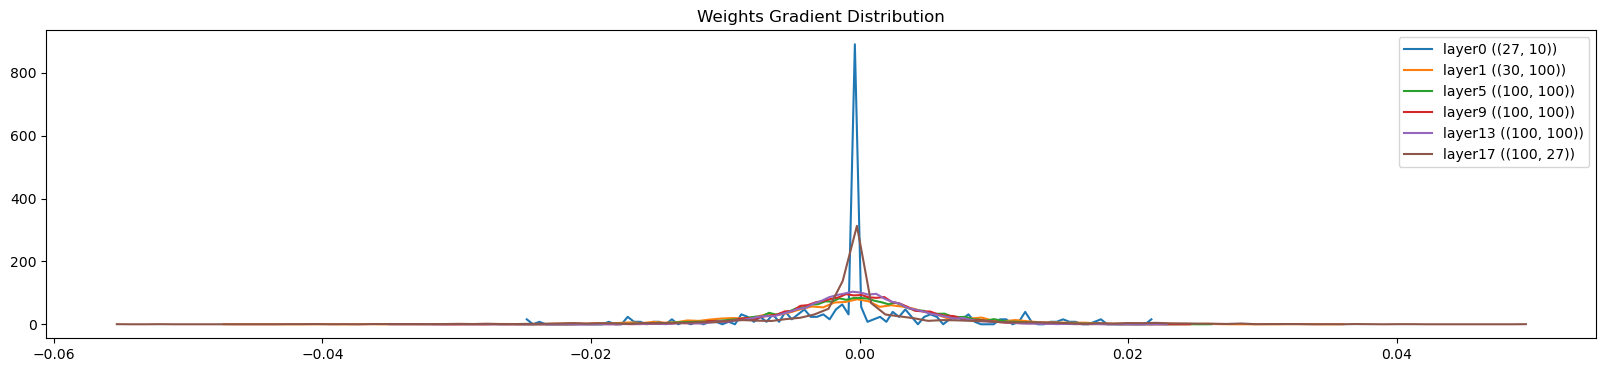

In [165]:
# Visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # dim 2 makes it only check for weights not biases, gamma and beta
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer{i} ({tuple(p.shape)})')
plt.legend(legends)
plt.title('Weights Gradient Distribution')

Text(0.5, 1.0, 'Update to Gradient Distribution')

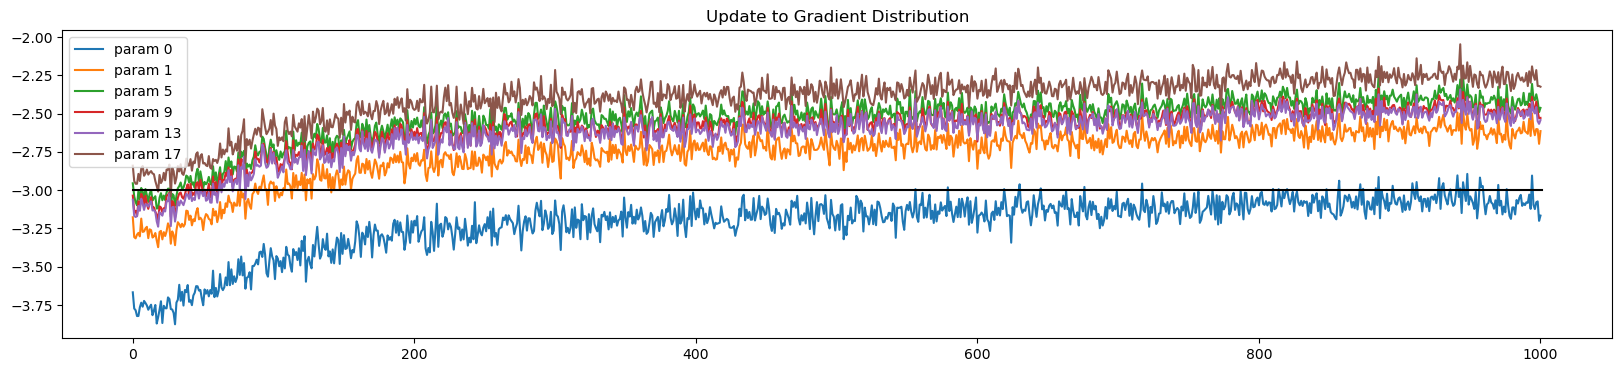

In [166]:
# Visualise histograms
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # dim 2 makes it only check for weights not biases, gamma and beta
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k') # values of 1e-3, indicate on plot
plt.legend(legends)
plt.title('Update to Gradient Distribution')

### Part 4: Implementing Backpropogation from Scratch

In [96]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [98]:
# build vocabulary of characters and mapping to and from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [99]:
# build a dataset

def build_dataset(words):
    block_size = 3  # context length: how many characters are taken to predict the next one
    X, Y = [], []

    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [100]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [101]:
# utility function to compare manual gradients to pytorch gradients

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {str(maxdiff)}')

In [102]:
n_emb = 10  # size of embeddings
n_hidden = 64  # number of neurons in hidden layer
vocab_size = len(stoi)  # number of unique characters in vocabulary
block_size = 3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g) # Embedding representations

#Layer 1
W1 = torch.randn((block_size*n_emb, n_hidden), generator=g) * ((5/3) / (block_size*n_emb)**0.5)  # multiplied with gain / root of fanin
b1 = torch.randn(n_hidden, generator=g) * 0.01 # removed as we are using bnbias, since we use mean and subtract (check batchnorm), gradient of b1 will be 0
# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1  # to keep initial value of W2 low so that while predicting logits gives uniformity
b2 = torch.randn(vocab_size, generator=g) * 0.1 # keep inital bias 0
# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) * 0.1 + 1 
bnbias = torch.zeros((1, n_hidden)) * 0.1

# Parameters
parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

Number of parameters: 4137


In [103]:
batch_size = 32
n = batch_size
# Construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

In [104]:
# Forward Pass
emb = C[Xb] # get embeddings
embcat = emb.view(emb.shape[0], -1) # concatenate vectors

# Linear Layer 1
hprebn = embcat @ W1  + b1 # pre activation

# Batch Norm Layers
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # Bessels correction dividing by n-1 not n
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw  + bnbias
# Hidden Layer - nonlinearity
h = torch.tanh(hpreact) # after activation
# Output Layer
logits = h @ W2 + b2 # log counts
# Loss same as using F.cross_entropy(logits, Yb)
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True) 
counts_sum_inv = counts_sum**-1 # if (1 / counts_sum) is used backprop cant be gotten to be exact
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
    p.grad=None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, 
          h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()

loss.backward()
loss

tensor(3.4619, grad_fn=<NegBackward0>)

In [106]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0/probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)  # broadcasting operation is taking place where inv is replicated and mutliplied, hence we sum accross axis 1
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-1*counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum # add to previous gradient for counts
dnorm_logits = norm_logits.exp() * dcounts
dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)
dlogits = 1 * dnorm_logits
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True) 
dbnraw = bngain * dhpreact
dbnbias = (dhpreact).sum(0, keepdim=True)
dbndiff = (bnvar_inv * dbnraw)
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)*torch.ones_like(bndiff2)) * dbnvar
dbndiff += 2*bndiff * dbndiff2
dhprebn = 1 * dbndiff
dbnmeani = (-1.0*dbndiff).sum(0, keepdim=True)
dhprebn += (1/n * torch.ones_like(hprebn)) * dbnmeani
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = (dhprebn).sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('dh', dh, h)
cmp('dW2', dW2, W2)
cmp('db2', db2, b2)
cmp('dhpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dW2             | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [107]:
# Backpropogate through cross entropy but in one step

# Forward pass
# Before
'''
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True) 
counts_sum_inv = counts_sum**-1 # if (1 / counts_sum) is used backprop cant be gotten to be exact
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
'''

loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff: ', (loss_fast - loss).item())

3.4618701934814453 diff:  -4.76837158203125e-07


In [108]:
# Backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n 

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 4.423782229423523e-09


In [110]:
# Backpropogate through batch norm but in one step

# Forward pass
# Before
'''
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # Bessels correction dividing by n-1 not n
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw  + bnbias
'''

hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True))

In [111]:
dhprebn = bngain * bnvar_inv/n *(n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
